# **Import Libraries**


In [ ]:
!pip install mplfinance -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 967.8 kB/s eta 0:00:00


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fe4bd677c25347b561e11fdc5df7a051e7b499982c715446b5c1b1ca446b93d9
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import tensorflow as tf
import keras
import yfinance as yf
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input, Flatten, BatchNormalization, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.models import Model

# **Loading the data**


In [ ]:
# Fetch Apple Stock data
aapl_data = yf.download('AAPL', start='2017-01-01', end='2024-01-01')

# Display the dataframe
aapl_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.921545,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.891418,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.028172,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.329483,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.579813,134247600
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868134,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700


# **Data Cleaning and EDA**


In [ ]:
# Checking for missing values
aapl_data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
# Filling missing values
aapl_data.fillna(method='ffill', inplace=True)

<ipython-input-6-abde7951f060>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl_data.fillna(method='ffill', inplace=True)


In [ ]:
# Display basic information about the dataframe
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1760 entries, 2017-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1760 non-null   float64
 1   High       1760 non-null   float64
 2   Low        1760 non-null   float64
 3   Close      1760 non-null   float64
 4   Adj Close  1760 non-null   float64
 5   Volume     1760 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.2 KB


In [ ]:
# Display descriptive statistics
aapl_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,99.955950,101.068367,98.920241,100.047322,97.989058,1.075000e+08
std,53.655976,54.245966,53.102108,53.701089,53.915873,5.381399e+07
min,28.950001,29.082500,28.690001,29.004999,26.891415,2.404830e+07
25%,46.526875,46.900624,46.174999,46.525624,44.296710,7.326460e+07
50%,91.264999,92.793751,90.738750,91.421249,89.180153,9.398185e+07
75%,148.830006,150.290001,147.434994,148.962505,146.881870,1.276278e+08
max,198.020004,199.619995,197.000000,198.110001,197.361084,4.479400e+08


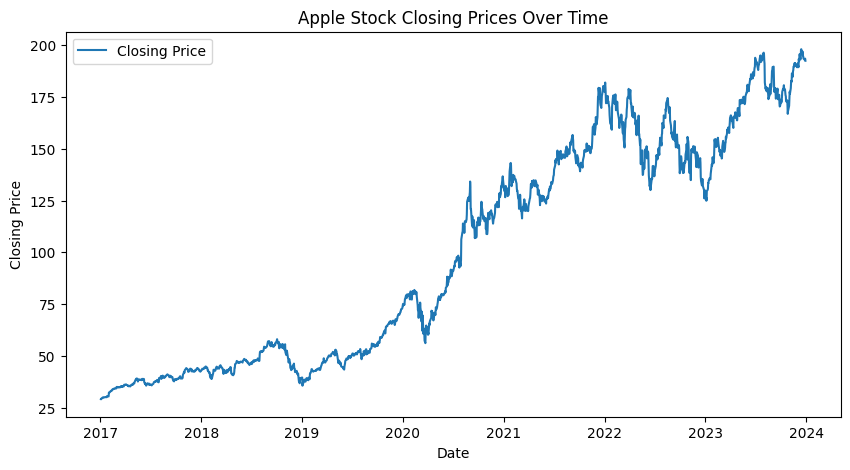

In [ ]:
# Plot the closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(aapl_data['Close'], label='Closing Price')
plt.title('Apple Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

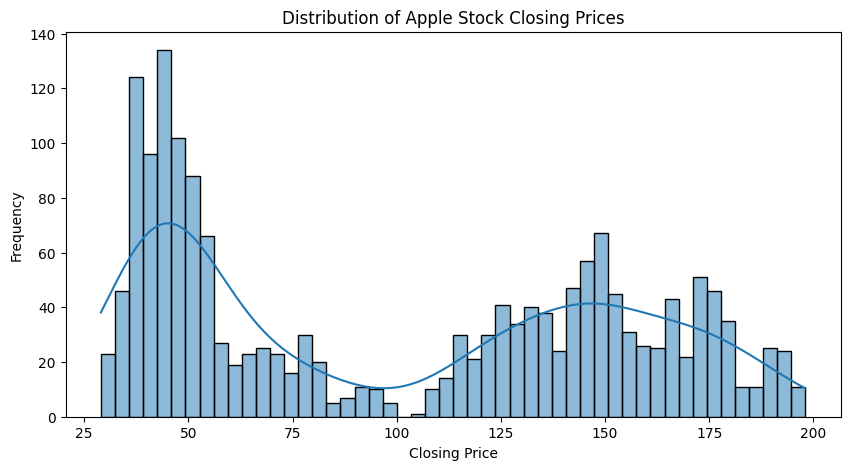

In [ ]:
# Plot the distribution of closing prices
plt.figure(figsize=(10, 5))
sns.histplot(aapl_data['Close'], bins=50, kde=True)
plt.title('Distribution of Apple Stock Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

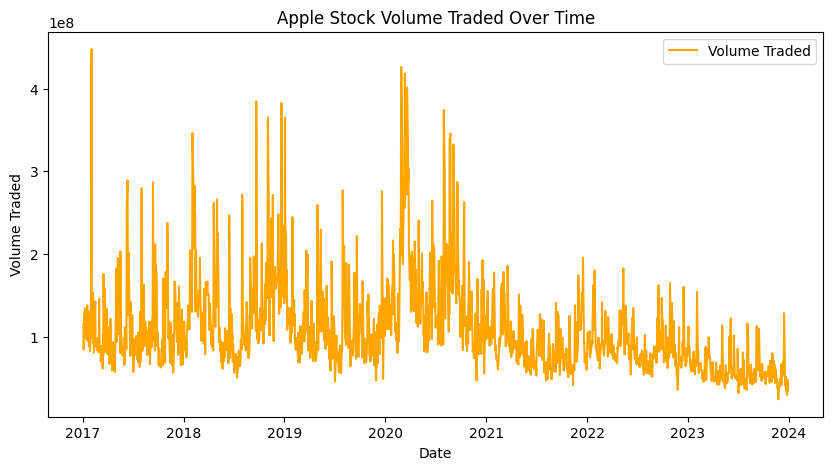

In [ ]:
# Plot the volume traded over time
plt.figure(figsize=(10, 5))
plt.plot(aapl_data['Volume'], label='Volume Traded', color='orange')
plt.title('Apple Stock Volume Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume Traded')
plt.legend()
plt.show()

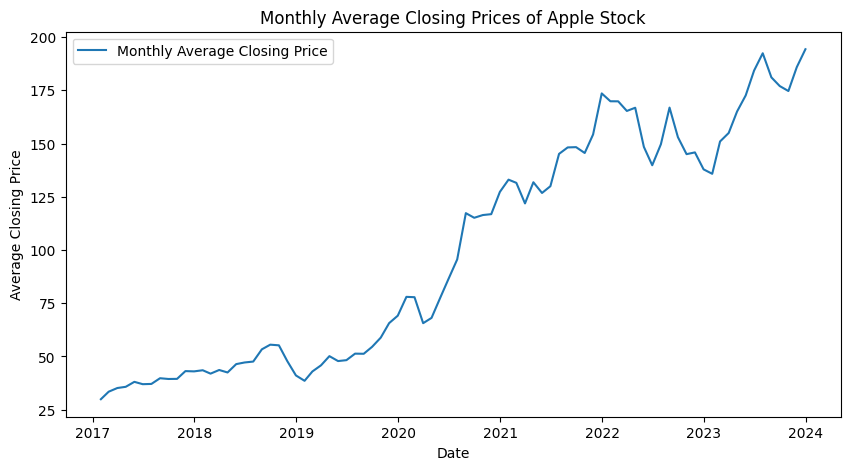

In [ ]:
# Calculate monthly average closing prices
monthly_avg_close = aapl_data['Close'].resample('M').mean()

# Plot monthly average closing prices
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_close, label='Monthly Average Closing Price')
plt.title('Monthly Average Closing Prices of Apple Stock')
plt.xlabel('Date')
plt.ylabel('Average Closing Price')
plt.legend()
plt.show()

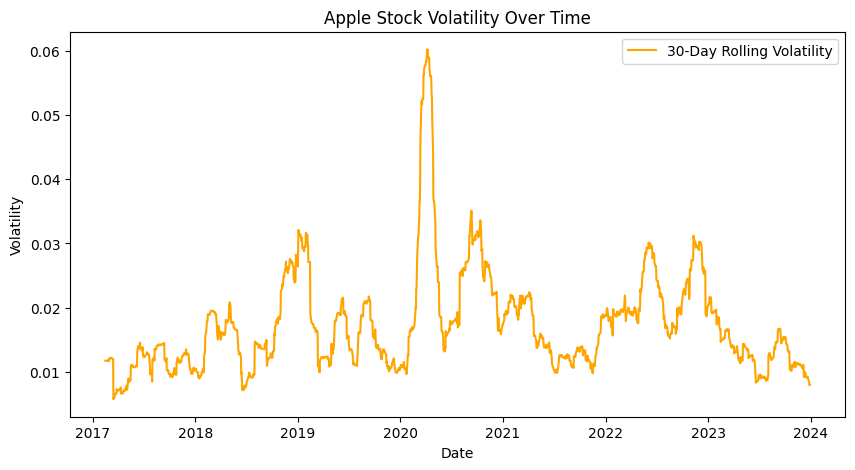

In [ ]:
# Calculate daily returns
aapl_data['Daily Return'] = aapl_data['Close'].pct_change()

# Calculate rolling standard deviation (volatility)
volatility = aapl_data['Daily Return'].rolling(window=30).std()

# Plot the volatility
plt.figure(figsize=(10, 5))
plt.plot(volatility, label='30-Day Rolling Volatility', color='orange')
plt.title('Apple Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

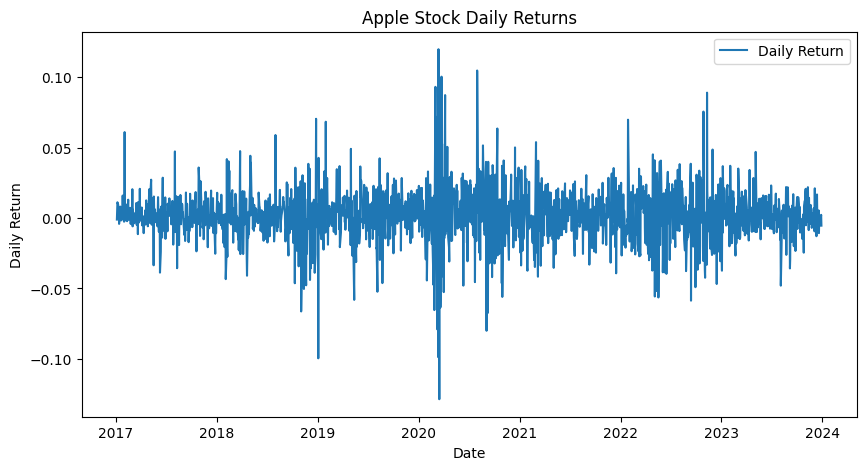

In [ ]:
# Plot daily returns
plt.figure(figsize=(10, 5))
plt.plot(aapl_data['Daily Return'], label='Daily Return')
plt.title('Apple Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

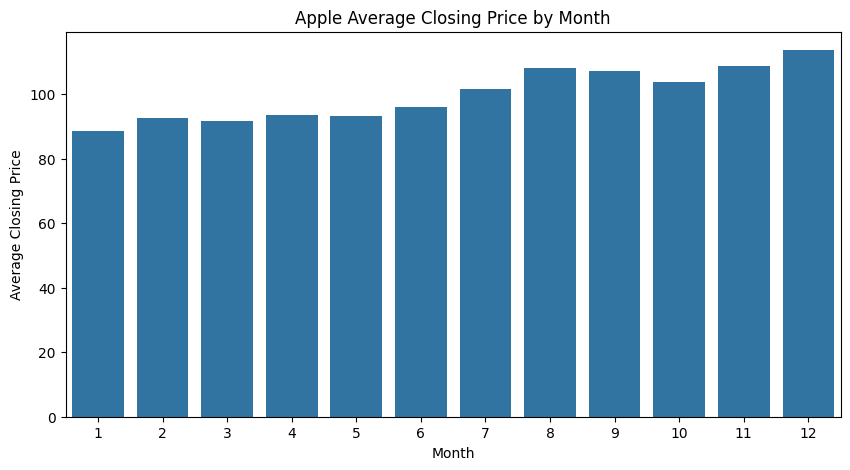

In [ ]:
# Extract the Month
aapl_data['Month'] = aapl_data.index.month

# Plot average closing price by month
plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Close', data=aapl_data, estimator=np.mean, errorbar=None)
plt.title('Apple Average Closing Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.show()

# **Data Preprocessing**


In [ ]:
# Create an instance of the MinMaxScaler class and fitting the scaler to the 'Close' column data and transforming it
scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [ ]:
# Initialize empty lists to store the input sequences (X) and corresponding target values (y)
X = []
y = []

# Loop over the scaled Apple stock data starting from the 60th data point to the end
for i in range(60, len(aapl_data_scaled)):
    # Append the previous 60 data points to the X list as a sequence
    # This creates a sliding window of 60 data points
    X.append(aapl_data_scaled[i-60:i, 0])
    # Append the current data point as the target value to the y list
    y.append(aapl_data_scaled[i, 0])


In [ ]:
# Determine the size of the training set as 80% and test set as 20% of the total dataset
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

# Split the input sequences (X) into training and test sets
X_train, X_test = X[:train_size], X[train_size:]

# Split the target values (y) into training and test sets
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Convert the lists X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the X_train array to have 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# **Base GRU Model**


## **Building the GRU Model**


In [ ]:
# Define the GRU model
model = Sequential()

# Add the first GRU layer with Dropout
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add the second GRU layer
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer for the output
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - loss: 0.0146 - val_loss: 8.1262e-04
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0013 - val_loss: 7.4448e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 9.1250e-04 - val_loss: 0.0012
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 6.6594e-04 - val_loss: 0.0026
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 8.1719e-04 - val_loss: 0.0018
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 7.1891e-04 - val_loss: 9.1765e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 6.9408e-04 - val_loss: 9.7913e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 6.0183e-04 - val_loss: 7.1736e-04
Epoch 

In [ ]:
# Compile the model
# MSE is commonly used for regression problems where we want to minimize the difference between predicted and actual values
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

## **Training the GRU Model**


In [ ]:
# Train the model using the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 3.1317e-04 - val_loss: 0.0042
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 2.5353e-04 - val_loss: 0.0059
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 2.9941e-04 - val_loss: 0.0055
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 2.5070e-04 - val_loss: 0.0029
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 2.9050e-04 - val_loss: 0.0076
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 2.2699e-04 - val_loss: 0.0094
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.7367e-04 - val_loss: 0.0085
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 2.2606e-04 - val_loss: 0.0064
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 2.1404e-04 - val_loss: 0.0064
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 2.2322e-04 - val_loss: 0.0037
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.8171e-04 - val_loss: 0.0057
Epoch 12

## **Evaluating the Performance of GRU Model**


In [ ]:
# Convert X_test and y_test to Numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape X_test to match the input shape used for X_train
# This ensures that the test data has the same dimensionality as the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)

# Print the test loss to see the performance of the model on the test data
print("Test Loss: ", test_loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033
Test Loss:  0.0031911043915897608


In [ ]:
# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the MAE and RMSE
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Mean Absolute Error:  0.05383960602647121
Root Mean Square Error:  0.05648986204330156


## **Predicting the next 4 days**


In [ ]:
# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Ensure we have at least 60 days of data
if len(closing_prices) < 60:
    raise ValueError("Not enough data to make a prediction")

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next day
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Price for the next day: ", predicted_stock_price)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Stock Price for the next day:  [[226.44626]]


In [ ]:
# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Stock Prices for the next 4 days:  [226.44626, 224.26538, 222.2675, 220.46411]


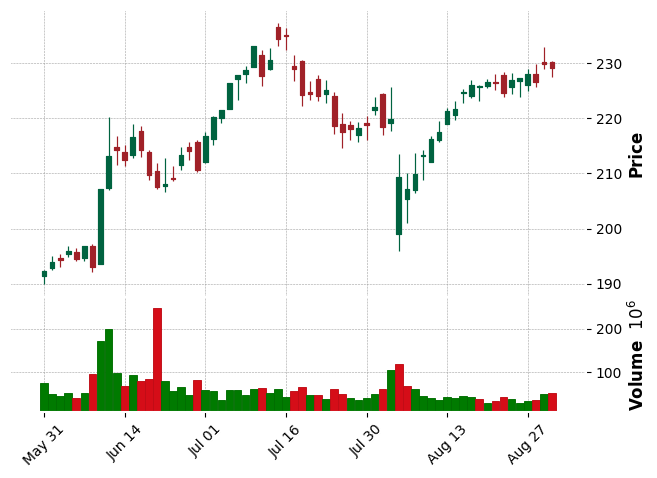

In [ ]:
# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)


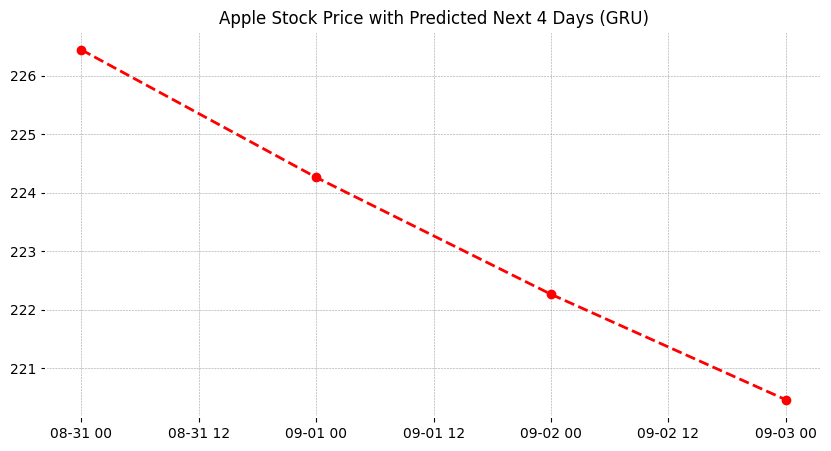

In [ ]:
# Overlaying the predicted data
plt.figure(figsize=(10,5))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("Apple Stock Price with Predicted Next 4 Days (GRU)")
plt.show()

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


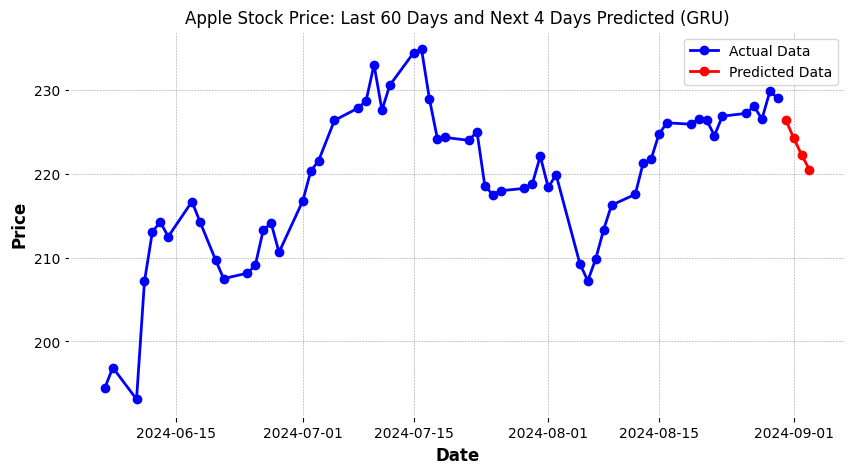

In [ ]:
# Fetch the last 3 months of Apple stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Last 60 days

# Predicting 4 days
for i in range(4):
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data and 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,5))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("Apple Stock Price: Last 60 Days and Next 4 Days Predicted (GRU)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **GRU Model with Feature Engineering**


## **Calculating Technical Indicators**


In [ ]:
# 50-day Moving Average
aapl_data['50_MA'] = aapl_data['Close'].rolling(window=50).mean()

# 100-day Moving Average
aapl_data['100_MA'] = aapl_data['Close'].rolling(window=100).mean()

In [ ]:
# Relative Strength Index (RSI)
aapl_data['RSI'] = ta.momentum.RSIIndicator(close=aapl_data['Close'], window=14).rsi()

In [ ]:
# MACD
macd = ta.trend.MACD(close=aapl_data['Close'])
aapl_data['MACD'] = macd.macd()
aapl_data['MACD_Signal'] = macd.macd_signal()
aapl_data['MACD_Hist'] = macd.macd_diff()

In [ ]:
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=aapl_data['Close'], window=20, window_dev=2)
aapl_data['Bollinger_High'] = bollinger.bollinger_hband()
aapl_data['Bollinger_Low'] = bollinger.bollinger_lband()

In [ ]:
# Volume Exponential Moving Average (Volume_EMA)
aapl_data['Volume_EMA'] = aapl_data['Volume'].ewm(span=21).mean()

In [ ]:
# Drop any NaN values created during feature engineering
aapl_data.dropna(inplace=True)

## **Data Preprocessing**


In [ ]:
# Selecting the features to use for training
features = ['Close', '50_MA', '100_MA', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'Volume_EMA']

# Scale the selected features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_data[features])

In [ ]:
# Scale the selected features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_data[features])

# Define X and y for the model, using a sliding window approach
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])  # Using the last 60 time steps
    y.append(scaled_data[i, 0])    # Predicting the 'Close' price

X, y = np.array(X), np.array(y)

In [ ]:
# Splitting into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## **Building the GRU Model**


In [ ]:
# Define the GRU model
model = Sequential()

# First GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Training the GRU Model**


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0263 - val_loss: 0.0036
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/

In [ ]:
# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           9,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,805 (300.02 KB)

 Trainable params: 25,601 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,204 (200.02 KB)

## **Evaluating the Performance of GRU Model**


In [ ]:
# Ensure X_test has the correct shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)

# Print the test loss to see the performance of the model on the test data
print("Test Loss: ", test_loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028
Test Loss:  0.004311504308134317


In [ ]:
# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the MAE and RMSE
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Mean Absolute Error:  0.05951461188596189
Root Mean Square Error:  0.06566204587440498


## **Predicting the next 4 days**


In [ ]:
# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select the 'Close' price and convert to numpy array
closing_prices = data['Close'].values

# Ensure we have at least 60 days of data
if len(closing_prices) < 60:
    raise ValueError("Not enough data to make a prediction")

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Use the last 60 days to predict the next day
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Replicate across the correct number of dimensions to match the training
num_features = 8
X_latest = np.repeat(X_latest[..., np.newaxis], num_features, axis=-1)

# Ensure X_latest has the correct shape and data type
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], num_features))
X_latest = X_latest.astype('float32')

# Make predictions for the next day
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price[:, 0].reshape(-1, 1))

print("Predicted Stock Price for the next day:", predicted_stock_price)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Stock Price for the next day: [[223.7295]]


In [ ]:
# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
num_features = 8
timesteps = 60

# Prepare the initial input batch with the correct number of features and timesteps
# Replicating the closing price across the number of features
current_batch = np.repeat(scaled_data[-timesteps:].reshape(1, timesteps, 1), num_features, axis=-1)

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Since next_prediction is a scalar, expand it across the number of features
    next_prediction_expanded = np.repeat(next_prediction.reshape(1, 1), num_features, axis=-1).reshape(1, 1, num_features)

    # Update the current batch by removing the oldest data point and adding the new prediction
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_expanded, axis=1)

    # Inverse transform the first feature of the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction.reshape(-1, 1))[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Stock Prices for the next 4 days:  [223.7295, 222.98439, 222.40854, 221.97717]


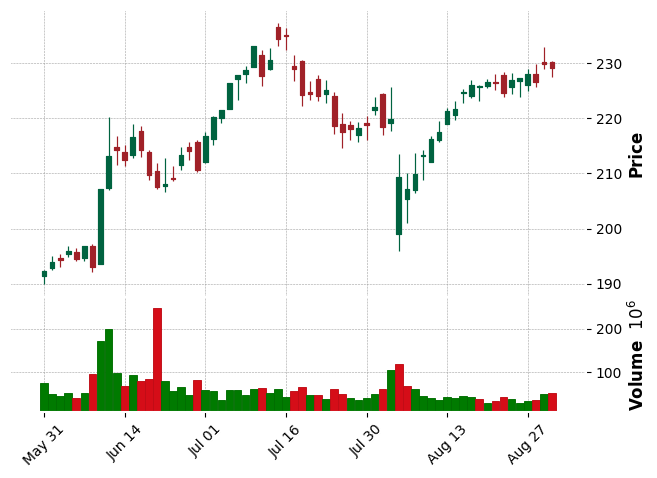

In [ ]:
# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)


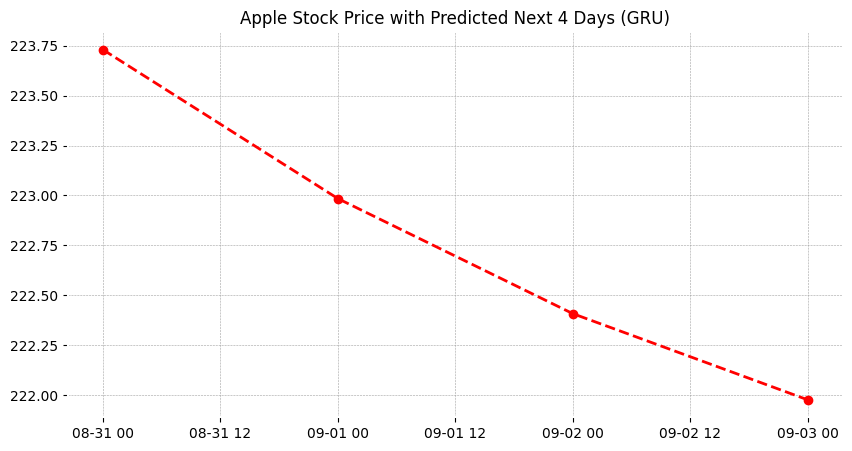

In [ ]:
# Overlaying the predicted data
plt.figure(figsize=(10,5))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("Apple Stock Price with Predicted Next 4 Days (GRU)")
plt.show()

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


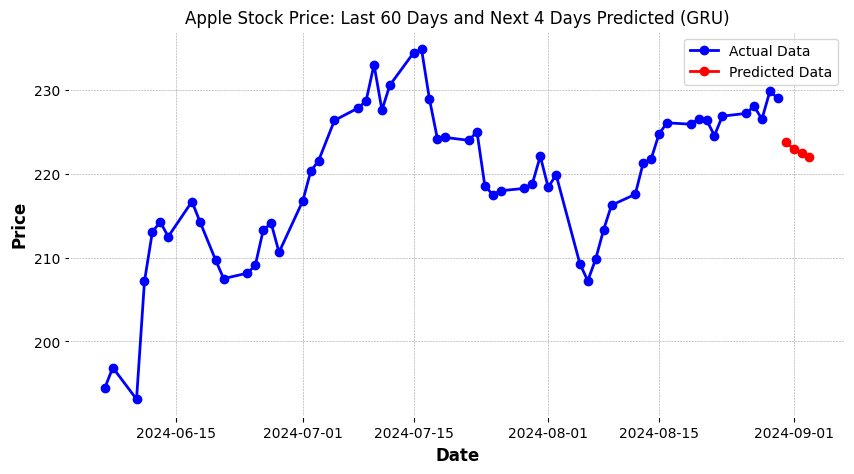

In [ ]:
# Fetch the last 3 months of Apple stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

num_features = 8

# Repeat the single feature across the expected number of features
current_batch = np.repeat(scaled_data[-60:].reshape(1, 60, 1), num_features, axis=-1)

# Now predict the next 4 days iteratively
predicted_prices = []
for i in range(4):
    next_prediction = model.predict(current_batch)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Update current_batch by adding the new prediction and removing the oldest data point
    next_prediction_reshaped = np.repeat(next_prediction.reshape(1, 1, 1), num_features, axis=-1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

# Create a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Combine predictions with the actual data
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])
combined_data = pd.concat([data['Close'], predicted_data['Close']])

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')
plt.title("Apple Stock Price: Last 60 Days and Next 4 Days Predicted (GRU)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()